<a href="https://colab.research.google.com/github/MadhumithaBoopathi/Codsoft/blob/main/MiniprojectResult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import shutil
import os

# Load metadata

# List all files and directories in the extracted folder to understand the structure
esc50_df = pd.read_csv('/content/drive/MyDrive/Sound dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')
# Expanded dangerous and non-dangerous classes
esc_dangerous = ['scream', 'thunderstorm', 'gun_shot', 'chainsaw', 'glass breaking', 'crying_baby', 'fireworks', 'explosion', 'helicopter', 'air_conditioner']
esc_non_dangerous = ['keyboard_typing', 'rain', 'clock_tick', 'dog', 'wind', 'footsteps', 'birds', 'cat', 'piano']

# Filter categories
esc_dangerous_df = esc50_df[esc50_df['category'].isin(esc_dangerous)]
esc_non_dangerous_df = esc50_df[esc50_df['category'].isin(esc_non_dangerous)]

# Check how many samples we have in each category
print("Dangerous Sounds Count:\n", esc_dangerous_df['category'].value_counts())
print("\nNon-Dangerous Sounds Count:\n", esc_non_dangerous_df['category'].value_counts())

# Sample 300 from each (with replacement if there aren't enough samples)
dangerous_sample = esc_dangerous_df.sample(n=300, random_state=42, replace=True)  # Ensure you have 300 samples
non_dangerous_sample = esc_non_dangerous_df.sample(n=300, random_state=42, replace=True)

# Output directories
dangerous_dir = 'Dangerous_Sounds'
non_dangerous_dir = 'Non_Dangerous_Sounds'

os.makedirs(dangerous_dir, exist_ok=True)
os.makedirs(non_dangerous_dir, exist_ok=True)

# Copy dangerous sounds
for _, row in dangerous_sample.iterrows():
    shutil.copy(os.path.join('/content/drive/MyDrive/Sound dataset/ESC-50-master/ESC-50-master/audio', row['filename']), dangerous_dir)

# Copy non-dangerous sounds
for _, row in non_dangerous_sample.iterrows():
    shutil.copy(os.path.join('/content/drive/MyDrive/Sound dataset/ESC-50-master/ESC-50-master/audio', row['filename']), non_dangerous_dir)

print("Extraction complete. 300 dangerous and 300 non-dangerous samples.")

Dangerous Sounds Count:
 category
thunderstorm    40
fireworks       40
chainsaw        40
helicopter      40
crying_baby     40
Name: count, dtype: int64

Non-Dangerous Sounds Count:
 category
dog                40
keyboard_typing    40
wind               40
footsteps          40
rain               40
clock_tick         40
cat                40
Name: count, dtype: int64
Extraction complete. 300 dangerous and 300 non-dangerous samples.


In [ ]:
print(f"Total dangerous samples: {len(os.listdir(dangerous_dir))}")
print(f"Total non-dangerous samples: {len(os.listdir(non_dangerous_dir))}")

Total dangerous samples: 146
Total non-dangerous samples: 178


In [ ]:
import numpy as np
import librosa
import os
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Example function to extract MFCCs
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Transpose to have time as the first axis

# Load and preprocess data (dangerous and non-dangerous)
dangerous_samples = [extract_mfcc(os.path.join(dangerous_dir, file)) for file in os.listdir(dangerous_dir)]
non_dangerous_samples = [extract_mfcc(os.path.join(non_dangerous_dir, file)) for file in os.listdir(non_dangerous_dir)]

# Labels: 1 for dangerous, 0 for non-dangerous
dangerous_labels = [1] * len(dangerous_samples)
non_dangerous_labels = [0] * len(non_dangerous_samples)

# Combine the data
X = np.array(dangerous_samples + non_dangerous_samples)
y = np.array(dangerous_labels + non_dangerous_labels)

# Reshape to match Conv2D input (add the channel dimension)
X = np.expand_dims(X, axis=-1)  # Shape (samples, time_steps, n_features, 1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build CRNN Model
def build_crnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional Layers (Extract features from spectrograms)
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Reshaping for LSTM input (sequence processing)
    model.add(layers.Reshape((-1, 128)))  # Adjust based on your spectrogram's shape

    # Recurrent Layers (LSTM)
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(128))

    # Dense Output Layer (Final Classification)
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build model (Adjust input shape based on MFCC dimensions)
input_shape = X_train[0].shape  # Each input will have shape (time_steps, n_features, 1)
model = build_crnn_model(input_shape, num_classes=2)

# Train the model
history = model.fit(X_train, y_train, epochs=75, batch_size=32, validation_data=(X_val, y_val))

# Save the model for future use
model.save('crnn_sound_classification_model.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.5693 - loss: 0.6979 - val_accuracy: 0.4923 - val_loss: 0.7980
Epoch 2/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.6020 - loss: 0.6893 - val_accuracy: 0.4923 - val_loss: 0.7242
Epoch 3/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 628ms/step - accuracy: 0.6070 - loss: 0.6543 - val_accuracy: 0.5077 - val_loss: 0.7229
Epoch 4/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.6562 - loss: 0.6381 - val_accuracy: 0.5692 - val_loss: 0.6729
Epoch 5/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - accuracy: 0.6225 - loss: 0.6521 - val_accuracy: 0.4462 - val_loss: 0.7634
Epoch 6/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.6063 - loss: 0.6695 - val_accuracy: 0.4923 - val_loss: 0.7411
Epoch 7/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - accuracy: 0.5994 - loss: 0.6563 - val_accuracy: 0.5846 - val_loss: 0.6815
Epoch 8/75
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.6588 - loss: 0.6464 - val_accuracy: 0.5692 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8566 - loss: 0.4088
Validation Accuracy: 86.15%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation or test set
y_pred = model.predict(X_val)
y_pred_labels = y_pred.argmax(axis=1)

# Print metrics
print(classification_report(y_val, y_pred_labels, target_names=['Non-Dangerous', 'Dangerous']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
               precision    recall  f1-score   support

Non-Dangerous       0.93      0.78      0.85        32
    Dangerous       0.82      0.94      0.87        33

     accuracy                           0.86        65
    macro avg       0.87      0.86      0.86        65
 weighted avg       0.87      0.86      0.86        65



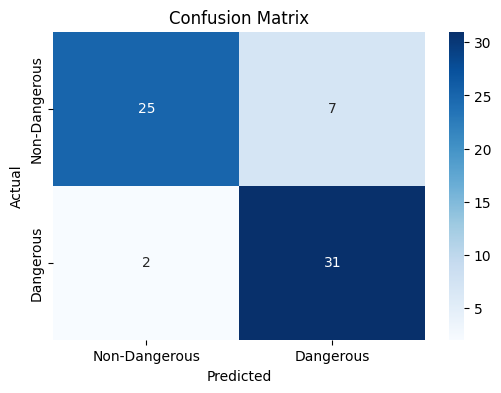

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Dangerous', 'Dangerous'], yticklabels=['Non-Dangerous', 'Dangerous'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

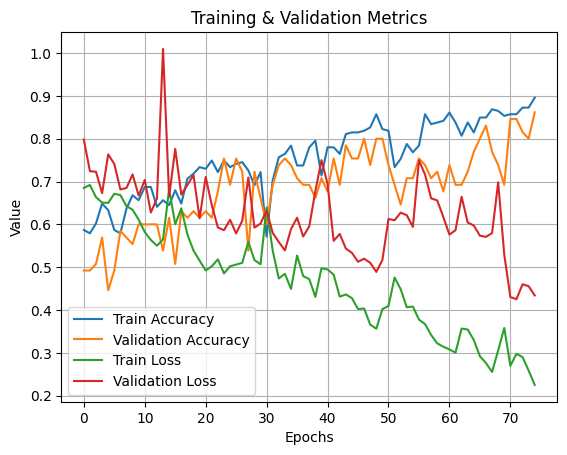

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.title('Training & Validation Metrics')
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('crnn_sound_classification_model.h5')

In [ ]:
import librosa
import numpy as np

def preprocess_audio(file_path, n_mfcc=13, expected_len=431):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T

    # Pad or truncate
    if mfcc.shape[0] < expected_len:
        pad_width = expected_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:expected_len, :]

    # Reshape for CRNN input
    mfcc = np.expand_dims(mfcc, axis=-1)  # shape (time_steps, n_mfcc, 1)
    mfcc = np.expand_dims(mfcc, axis=0)   # shape (1, time_steps, n_mfcc, 1)

    return mfcc

In [ ]:
file_path = '/content/drive/MyDrive/glass-breaking-94894.wav'

In [ ]:

# Preprocess and predict
input_data = preprocess_audio(file_path)
prediction = model.predict(input_data)

# Output result
class_names = ['Non-Dangerous', 'Dangerous']  # 0 = Non-Dangerous, 1 = Dangerous
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prediction: {class_names[predicted_class]} ({confidence * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediction: Dangerous (80.04%)


In [ ]:
file_path = '/content/drive/MyDrive/car-starting-sound-126708.wav'

In [ ]:

# Preprocess and predict
input_data = preprocess_audio(file_path)
prediction = model.predict(input_data)

# Output result
class_names = ['Non-Dangerous', 'Dangerous']  # 0 = Non-Dangerous, 1 = Dangerous
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prediction: {class_names[predicted_class]} ({confidence * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction: Non-Dangerous (99.15%)
